In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

In [ ]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_blur(img, kernel_size):  
    return cv2.medianBlur(img, kernel_size)
    
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def get_y_intercept(lane_lines, slopes):
    slopes = slopes[~np.isnan(slopes)]
    slopes = slopes[~np.isinf(slopes)]
    avg_slope = slopes.mean()
    lane_lines = lane_lines.reshape((lane_lines.shape[0]*2, lane_lines.shape[1]//2))
    x_min, y_min = np.mean(lane_lines, axis=0)
    return y_min - (x_min*avg_slope), avg_slope

def get_x_intercepts(y_1, y_2, slope, b):
    if not (~np.isnan(slope) and ~np.isnan(b)):
        x_1 = x_2 = 0.0
    else:
        x_1 = (y_1 - b)/slope
        x_2 = (y_2 - b)/slope
    return x_1, x_2

prev_left_x1 = 0
prev_left_x2 = 0
prev_right_x1 = 0 
prev_right_x2 = 0 
prev_left_avg_m = 0
prev_right_avg_m = 0
pev_left_avg_m = -1
prev_right_avg_m = 1
prev_left_b = 0
prev_right_b = 0
prev_left_line = 0
prev_right_line = 0

def draw_lines_extrapolated(img, lines, color=[255, 0, 0], thickness=10):
    imgshape = img.shape
    lines = lines.reshape((lines.shape[0], lines.shape[2]))
    y_min = lines.reshape((lines.shape[0]*2, lines.shape[1]//2))[:,1].min()
    
    # slope= (    y2      -     y1   )/(    x2     -     x1    )  
    slopes = (lines[:,3] - lines[:,1])/(lines[:,2] - lines[:,0])
    slopes = slopes[~np.isinf(slopes)]
    slopes = slopes[~np.isnan(slopes)]
    left_lines = lines[slopes < -0.5]   # Left  lines should have negative slope, thershold=-0.5
    right_lines= lines[slopes > 0.5]   # Right lines should have positive slope, threshold=+0.5
    left_slopes = slopes[slopes < -0.5]
    right_slopes= slopes[slopes > 0.5]
    
    global prev_left_avg_m 
    global prev_right_avg_m 
    global prev_left_b
    global prev_right_b
    
    left_b, left_avg_m = get_y_intercept(left_lines, left_slopes)
    right_b, right_avg_m = get_y_intercept(right_lines, right_slopes)

    keep_prev_left = False
    keep_prev_right = False
    
    if left_avg_m < -0.83 or left_avg_m > -0.36:
        left_avg_m = prev_left_avg_m
        left_b = prev_left_b
        keep_prev_left = True
    if right_avg_m > 0.83 or right_avg_m < 0.36:
        right_avg_m = prev_right_avg_m
        right_b = prev_right_b
        keep_prev_right = True
       
    """
    # For challenge video
    if left_avg_m < -0.83 or left_avg_m > -0.57:
        left_avg_m = prev_left_avg_m
        left_b = prev_left_b
        keep_prev_left = True
    if right_avg_m > 0.83 or right_avg_m < 0.57:
        right_avg_m = prev_right_avg_m
        right_b = prev_right_b
        keep_prev_right = True
    """
  
    prev_left_avg_m = left_avg_m 
    prev_right_avg_m = right_avg_m
    prev_left_b = left_b
    prev_right_b = right_b
    
    # using y_min, avg_slope and y_intercept find x1 and x2
    left_x1, left_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=left_avg_m, b=left_b)
    right_x1, right_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=right_avg_m, b=right_b)
    
    ##  Apply first order filter ##
    global prev_left_x1
    global prev_left_x2
    global prev_right_x1 
    global prev_right_x2 

    if prev_left_x1 != 0 or prev_left_x2 != 0 or prev_right_x1 != 0 or prev_right_x2 !=0:
        alpha = 0.2
        left_x1_new = math.floor((alpha)*left_x1 + (1-alpha)*prev_left_x1)
        left_x2_new = math.floor((alpha)*left_x2 + (1-alpha)*prev_left_x2)
        right_x1_new = math.floor((alpha)*right_x1 + (1-alpha)*prev_right_x1)
        right_x2_new = math.floor((alpha)*right_x2 + (1-alpha)*prev_right_x2)
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new
    else:
        left_x1_new = left_x1
        left_x2_new = left_x2
        right_x1_new = right_x1
        right_x2_new = right_x2
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new

    left_line = np.array([left_x1_new, y_min, left_x2_new, imgshape[0]], dtype=np.int32)
    right_line = np.array([right_x1_new, y_min, right_x2_new, imgshape[0]], dtype=np.int32)
    
    if keep_prev_left:
        left_line = prev_left_line
        left_x1_new = prev_left_x1
        left_x2_new = prev_left_x2
    if keep_prev_right:
        right_line = prev_right_line
        right_x1_new = prev_right_x1
        right_x2_new = prev_right_x2
        
    cv2.line(img, (int(left_x1_new), int(y_min)), (int(left_x2_new), imgshape[0]), color, thickness)
    cv2.line(img, (int(right_x1_new), int(y_min)), (int(right_x2_new), imgshape[0]), color, thickness)        
        
    ## End first order filter  ##    
    
    """
    ## Without first order filter - Lines will wobble a bit. ##
    
    if not keep_prev_left:
        left_line = np.array([left_x1, y_min, left_x2, imgshape[0]], dtype=np.int32)
    else:
        left_line = prev_left_line
        
    if not keep_prev_right:
        right_line = np.array([right_x1, y_min, right_x2, imgshape[0]], dtype=np.int32)
    else:
        right_line = prev_right_line
            
    cv2.line(img, (int(left_x1), int(y_min)), (int(left_x2), imgshape[0]), color, thickness)
    cv2.line(img, (int(right_x1), int(y_min)), (int(right_x2), imgshape[0]), color, thickness) 
    
    ## Without first order filter ##
    """
   
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, extrapolate=False, curvy=False):
    """
    `img` should be the output of a Canny transform.
    `rho` = distance resolution in pixels of the Hough grid
    `theta` = angular resolution in radians of the Hough grid
    `threshold` = minimum number of votes (intersections in Hough grid cell)
    `min_line_len` = minimum number of pixels making up a line
    `max_line_gap` = maximum gap in pixels between connectable line segments
    Returns an image with hough lines drawn.
    """ 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if not extrapolate and not curvy:
        draw_lines(line_img, lines)
    elif extrapolate:
        draw_lines_extrapolated(line_img, lines)
    else:
        draw_lines_curvy(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

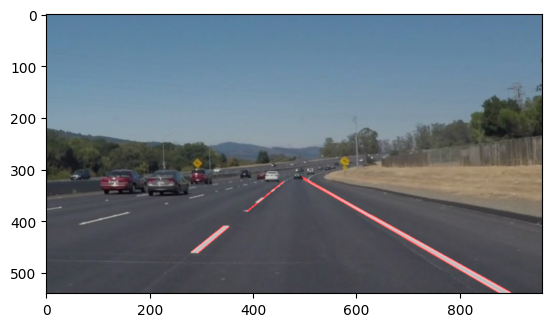

In [3]:
img = mpimg.imread('test_images/solidWhiteCurve.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=20)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes)

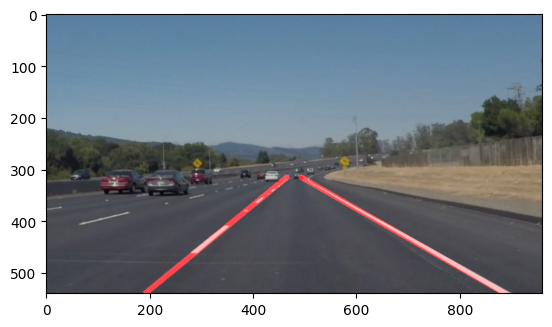

In [4]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=20, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

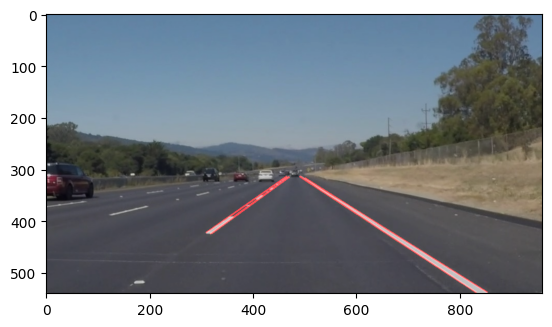

In [5]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=40)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

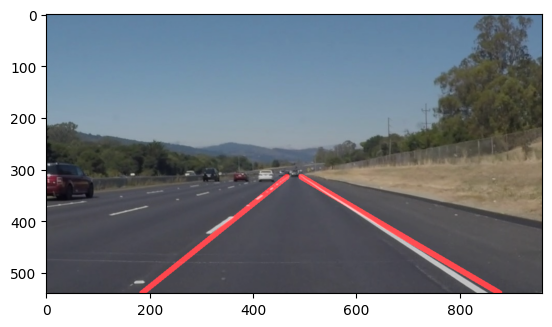

In [6]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=40, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

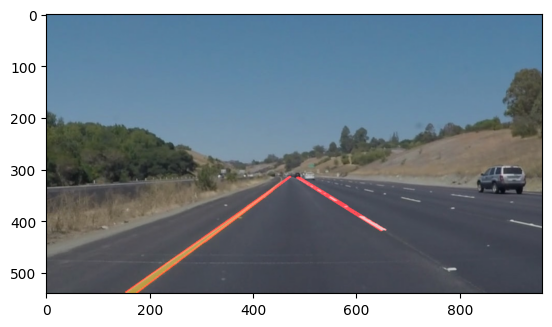

In [7]:
img = mpimg.imread('test_images/solidYellowCurve.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=30)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

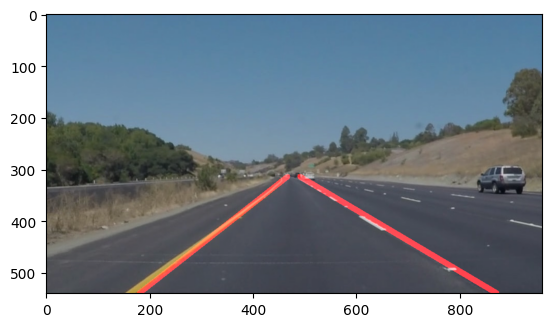

In [8]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=30, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

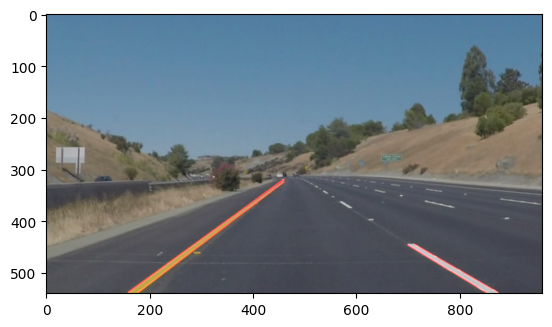

In [9]:
img = mpimg.imread('test_images/solidYellowCurve2.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=60,
                              min_line_len=60, max_line_gap=30)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

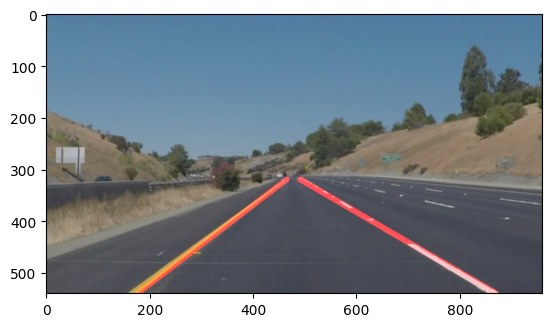

In [10]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=60,
                              min_line_len=60, max_line_gap=30, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

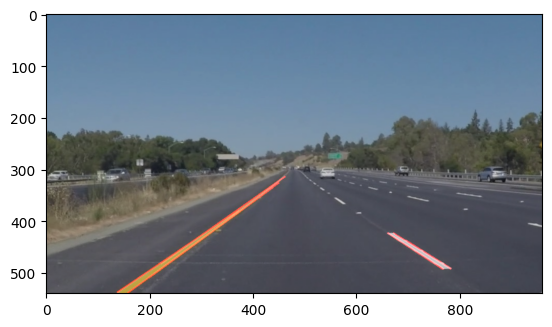

In [11]:

img = mpimg.imread('test_images/solidYellowLeft.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=60, 
                              min_line_len=60, max_line_gap=30)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

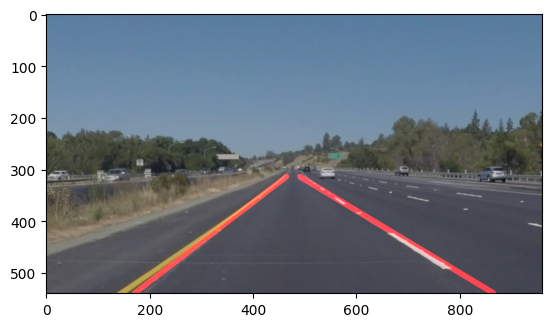

In [12]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=60, 
                              min_line_len=60, max_line_gap=30, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)

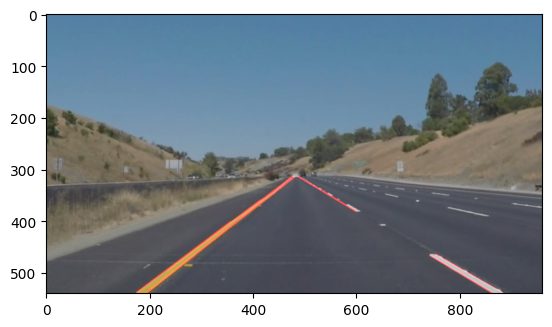

In [13]:
img = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
img_shape= img.shape
img_gray = grayscale(img)
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)
img_masked_edges = region_of_interest(img_edge, vertices)
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=80,
                              min_line_len=60, max_line_gap=30)
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, α=0.8, β=1., λ=0.)

plt.imshow(img_lanes)

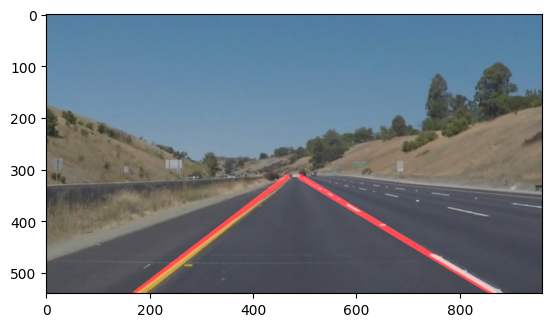

In [14]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=80,
                              min_line_len=60, max_line_gap=30, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, α=0.8, β=1., λ=0.)
plt.imshow(img_lanes_extrapolated)